# C964 Capstone Project - Fake News Classifier
This project utilizes binary logistic regression to classify news articles between fake or true news.

This project implements multiple libraries to achieve the goal of classifying news articles:
 1. Pandas - for csv document parsing of datasets.
 2. re & nltk - cleaning and formatting text to reduce noise for the model.
 3. sklearn - Commonly known as scikit-learn, is a free and open-scource machine learning library. Provides all the tools for implementing, training, and testing a model.
 4. seaborn & matplotlib - Work in tangent to display visual graphs of the training data.

 Libraries included for ease of testing for course evaluators:
  1. requests - A library used for sending HTTP/1.1 requests to a url or ip. A default get request is sent for testing purposes.
  2. BeautifulSoup & lxml parser - Used to parse the html returned from the requests get request.

## Dataset Parsing, Concatenation, and Split
The pandas library is imported and used to:
- Parse and Concatenate the fake and true datasets

Additionally, a column to label true or false data is given with the name of 'label' and true or false as '1' or '0'.
The dataset is shuffled and the ID for each row is reset to ensure no duplicates in ID.

In [1]:
import pandas as pd

fake_ds = pd.read_csv('dataset/Fake.csv')
true_ds = pd.read_csv('dataset/True.csv')

fake_ds['label'] = 0
true_ds['label'] = 1

ds = pd.concat([fake_ds, true_ds])
ds = ds.sample(frac=1, random_state=42).reset_index(drop=True)

## Dataset Cleaning
The nltk library is utilized to download stopwords that are more or less words that do not add to the meaning or intent of a sentence.
The re library is utilized to strip sentences of everythink that is not a number or letter.

The article header and the article text are combined to replace the article text column, with the aforementioned stripped from the dataset.

In [2]:
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def process_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ' '.join([word for word in text.split() if word not in stop_words])
ds['text'] = ds['title']  + ' ' + ds['text']
ds['text'] = ds['text'].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zmorr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Creation of Test Dataset
The test dataset is created, as 25% of the total dataset.

In [3]:
from sklearn.model_selection import train_test_split

x = ds['text']
y = ds['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

## Test and Train Sets Vectorization
The test and train sets are vectorized into a format more understandable by the model.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=5000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

## Train Model
The model is initialized and trained using the vectorized training data.

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(x_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Test Model
The model is testing and textual data is printed to display the accuracy and f1 scores of the model.

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model.predict(x_test_vec)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.987706013363029
[[5788   83]
 [  55 5299]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.98      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Confusion Map Creation and Display
seaborn plots training data compared to actual data on a confusion matrix through matplotlib.
The matrix is then shown to the user.

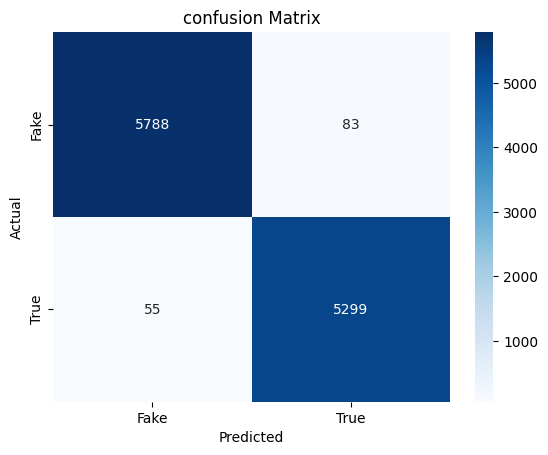

In [7]:
import seaborn as sb
import matplotlib.pyplot as plot

sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])

plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('confusion Matrix')
plot.show()

## Function for Model Predictions
A function to pass an url and the article to classify and print the results.

In [ ]:
def classifyArticle(url,article):
    clean_input = process_text(article)
    input_vector = vectorizer.transform([clean_input])
    prediction = model.predict(input_vector)
    print(f"The article from: {url} is found to be {'Fake' if prediction[0]==0 else 'Real'}")
    
    # This would essentially change from text to true or false
    # True or false would answer 'Is this a real article?'
    # return False if prediction[0]==0 else True

## Webscrape a Supplied Article URL
The use of the requests library to scrape a given URL as long as it is a valid (supported) domain.
The request is sent in a way to prevent blocking from the given domain, user-agent.
The request is stored as variable r.

In [15]:
import requests

article = None
while article is None:
    validDomains = { "cnn.com", "foxnews.com" }
    userInput = str(input("Enter the article's URL: "))
    
    for domain in validDomains:
        if domain in userInput:
            article = { "articleDomain": domain, "URL":userInput }
            break
    
    if article is None:
        print("Invalid domain, please use news from cnn.com or foxnews.com")

headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:140.0) Gecko/20100101 Firefox/140.0"}

r = requests.get(article["URL"], headers)

## BeautifulSoup HTML Parsing w/ lxml
Beatiful soup utilizes lxml to parse the result of request r from the previous code snippet.
A headlineClass and bodyClass is applied based on the structure of the supplied, supported, domain.
A call to the previous classifyArticle function, two code snippets ago, is made to classify the given article.

In [ ]:
from bs4 import BeautifulSoup

match article["articleDomain"]:
    case "cnn.com":
        headlineClass = "headline__text"
        bodyClass = "article__content"
    case "foxnews.com":
        headlineClass = "headline"
        bodyClass = "article-body"

soup = BeautifulSoup(r.text, "lxml")
headline = soup.find(class_=headlineClass).get_text()
body = soup.find(class_=bodyClass).get_text()

classifyArticle(article["URL"], headline + " " + body)



The article from: https://www.foxnews.com/world/iran-vows-retaliation-un-security-council-issues-snapback-sanctions-anniversary-nuclear-deal is found to be Real
